In [4]:
import os
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from accelerate import Accelerator
from pathlib import Path


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Google Drive Setup for saving the model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Directory to save the model
output_dir = "/content/drive/My Drive/saved_bert_model"
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
dataset = pd.read_csv("hf://datasets/dmitva/human_ai_generated_text/model_training_dataset.csv")  # Replace with your dataset file name


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
data = dataset.sample(frac=0.1, random_state=42)  # Use 10% of the data


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-9-33e1f349a1b0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


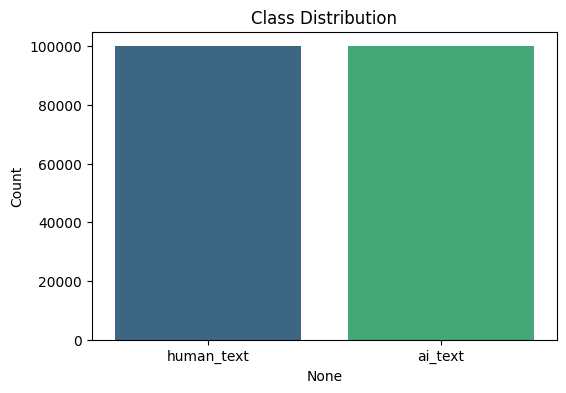

In [ ]:
class_counts = data[['human_text', 'ai_text']].apply(lambda x: len(x.dropna()), axis=0)
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()

In [ ]:
# Prepare the human and AI text data with labels
human_df = data[['human_text']].dropna().rename(columns={'human_text': 'text'})
human_df['label'] = 0  # Label for human-generated text
ai_df = data[['ai_text']].dropna().rename(columns={'ai_text': 'text'})
ai_df['label'] = 1  # Label for AI-generated text


In [ ]:
!nvidia-smi


Tue Jan 21 15:09:07 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Combine both into a single DataFrame
combined_df = pd.concat([human_df, ai_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# prompt: i want to see first ten rows of it

print(combined_df.head(10))

                                                text  label
0  By experimenting, you can learn which skills a...      1
1  That's why the principal should let the studen...      0
2  It has caused people to become dependent on it...      1
3  Im agree so the student can basically learn mo...      0
4  There are some students that feel that their w...      0
5  In this case we can created proyects that help...      0
6  This approach is especially effective in the c...      1
7  However, this type of learning may also be str...      1
8  My success was a direct result of my changing ...      1
9  A student attitude is important because help t...      0


In [ ]:
# Split the data into training, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    combined_df['text'], combined_df['label'], test_size=0.2, random_state=42
)

test_texts, val_texts, test_labels, val_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42
)

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenization and encoding function
def tokenize_and_encode(tokenizer, texts, labels, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values, dtype=torch.long)

    return input_ids, attention_masks, labels


In [ ]:
# Tokenize and encode data
train_input_ids, train_attention_masks, train_labels = tokenize_and_encode(
    tokenizer, train_texts, train_labels
)
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer, val_texts, val_labels
)
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer, test_texts, test_labels
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Create TensorDatasets
batch_size = 16  # Reduced for Colab free-tier
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Initialize Accelerator for FP16 training
accelerator = Accelerator(mixed_precision="fp16")
device = accelerator.device


In [ ]:
# Move model to device
model, optimizer, train_loader, val_loader = accelerator.prepare(
    model,
    AdamW(model.parameters(), lr=2e-5),
    train_loader,
    val_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training function with checkpointing
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            accelerator.backward(loss)
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = batch
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

        print(f"Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

        # Save the model checkpoint after each epoch
        model.save_pretrained(f"{output_dir}/epoch_{epoch+1}")
        tokenizer.save_pretrained(f"{output_dir}/epoch_{epoch+1}")



In [ ]:
# Train the model
train_model(model, train_loader, val_loader, optimizer, device)


Epoch 1, Training Loss: 0.0024989742070436476, Validation Loss: 0.0003566627025604248
Epoch 2, Training Loss: 0.0012285383991897105, Validation Loss: 7.530702352523803e-05
Epoch 3, Training Loss: 0.002613957082480192, Validation Loss: 0.0016399941086769104


In [7]:
import torch
from safetensors.torch import load_file

# Load the safetensors file
safetensors_path = "model.safetensors"
state_dict = load_file('/content/drive/My Drive/saved_bert_model/epoch_3/'+ safetensors_path)

# Verify the keys (optional)
print(f"Keys in the state_dict: {state_dict.keys()}")

# Save the state dictionary to a .pth file
pth_path = "model.pth"
torch.save(state_dict, '/content/drive/My Drive/saved_bert_model/'+pth_path)

print(f"Model saved in PyTorch format at {pth_path}")


Keys in the state_dict: dict_keys(['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.dense.bias', 'be

In [ ]:
import numpy as np

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Disable gradient computation
        for batch in test_loader:
            # Move all tensors in the batch to the same device as the model
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get the predictions
            predictions = torch.argmax(logits, dim=1)

            # Append to the result lists
            true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for metrics
            predicted_labels.extend(predictions.cpu().numpy())  # Move predictions back to CPU

    # Calculate accuracy
    accuracy = (np.array(true_labels) == np.array(predicted_labels)).mean()
    print(f"Accuracy: {accuracy:.4f}")


In [ ]:
# Evaluate the model
evaluate_model(model, test_loader, device)


Accuracy: 0.9998


In [ ]:
# Create a .h file for deployment
header_content = f"""
#ifndef BERT_MODEL_H
#define BERT_MODEL_H

#include <string>
const std::string MODEL_PATH = "{output_dir}/epoch_3";

#endif // BERT_MODEL_H
"""

with open("bert_model.h", "w") as f:
    f.write(header_content)

print("Model and tokenizer saved, header file created.")

Model and tokenizer saved, header file created.


In [ ]:

# Load the saved model and tokenizer
saved_model_dir = f"{output_dir}/epoch_3"  # Path to the last saved model
model = BertForSequenceClassification.from_pretrained(saved_model_dir)
tokenizer = BertTokenizer.from_pretrained(saved_model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to preprocess and predict on unseen data
def predict_unseen_data(model, tokenizer, texts, device, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

    return predictions.cpu().numpy()

# Provide unseen data
unseen_data = [
    "This is a sentence written by a human.",  # Example human-generated text
    "Generated text from an AI model could look like this."  # Example AI-generated text
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Text: This is a sentence written by a human.
Predicted Label: Human

Text: Generated text from an AI model could look like this.
Predicted Label: Human



In [ ]:
# Provide unseen data
unseen_data = [
    "Technology has become the cornerstone of modern society, revolutionizing the way we live, work, and communicate. From the rise of artificial intelligence and machine learning to the seamless integration of smart devices in our daily lives, technology continues to push the boundaries of innovation. It has transformed industries, enabling automation, enhancing efficiency, and creating opportunities for unprecedented growth. The advent of 5G networks and cloud computing has further accelerated connectivity, bringing the world closer than ever before. As we move forward, ethical considerations and sustainability will play a crucial role in shaping the future of technology, ensuring its advancements benefit humanity as a whole."  # Example AI-generated text
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: Technology has become the cornerstone of modern society, revolutionizing the way we live, work, and communicate. From the rise of artificial intelligence and machine learning to the seamless integration of smart devices in our daily lives, technology continues to push the boundaries of innovation. It has transformed industries, enabling automation, enhancing efficiency, and creating opportunities for unprecedented growth. The advent of 5G networks and cloud computing has further accelerated connectivity, bringing the world closer than ever before. As we move forward, ethical considerations and sustainability will play a crucial role in shaping the future of technology, ensuring its advancements benefit humanity as a whole.
Predicted Label: AI



In [ ]:
# Provide unseen data
unseen_data = [
    "Education is the foundation of personal growth and societal progress, empowering individuals to unlock their potential and contribute meaningfully to the world. It serves as a gateway to knowledge, fostering critical thinking, creativity, and problem-solving skills. In today's digital age, education has transcended traditional classrooms, with online learning platforms and virtual classrooms making knowledge accessible to people across the globe. The integration of technology, such as AI-driven personalized learning and interactive tools, has transformed the way students engage with content, tailoring experiences to their unique needs. As education evolves, its focus on inclusivity, adaptability, and lifelong learning ensures that individuals are equipped to thrive in an ever-changing world."
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: Education is the foundation of personal growth and societal progress, empowering individuals to unlock their potential and contribute meaningfully to the world. It serves as a gateway to knowledge, fostering critical thinking, creativity, and problem-solving skills. In today's digital age, education has transcended traditional classrooms, with online learning platforms and virtual classrooms making knowledge accessible to people across the globe. The integration of technology, such as AI-driven personalized learning and interactive tools, has transformed the way students engage with content, tailoring experiences to their unique needs. As education evolves, its focus on inclusivity, adaptability, and lifelong learning ensures that individuals are equipped to thrive in an ever-changing world.
Predicted Label: AI



In [ ]:
# Provide unseen data
unseen_data = [
    "Education is the root of personal growth and societal development, equipping individuals to explore their potential and contribute meaningfully to the world. It provides a gateway to knowledge, thus encouraging critical thinking, creativity, and problem-solving skills. Education has moved from the traditional classrooms into the virtual classrooms and online learning platforms in the digital age, making knowledge accessible to people worldwide. Technology, such as AI-driven personalized learning and interactive tools, has changed the way students interact with content, customizing experiences for each student. The evolution of education focuses on inclusivity, adaptability, and lifelong learning to prepare people for a constantly changing world."
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: Education is the root of personal growth and societal development, equipping individuals to explore their potential and contribute meaningfully to the world. It provides a gateway to knowledge, thus encouraging critical thinking, creativity, and problem-solving skills. Education has moved from the traditional classrooms into the virtual classrooms and online learning platforms in the digital age, making knowledge accessible to people worldwide. Technology, such as AI-driven personalized learning and interactive tools, has changed the way students interact with content, customizing experiences for each student. The evolution of education focuses on inclusivity, adaptability, and lifelong learning to prepare people for a constantly changing world.
Predicted Label: AI



In [ ]:
# Provide unseen data
unseen_data = [
    "Selecting a manufacturing process usually depends on the type of work and the volume of production. There are five main process types – job shop, batch, repetitive, continuous, and project. Noteworthy, there are many factors to consider when choosing a process, as each type has its advantages and disadvantages. This paper aims to describe the five basic process types by comparing and contrasting them using examples. Historically, people first mastered job shops and batches’ processes, while repetitive and continuous processes appeared only after the industrial revolution. Job shops involve the production of a variety of products in small quantities. This process requires great flexibility of equipment and high-skilled personnel, allowing a wide variety of work. Still, the drawbacks of this type include high cost per unit and complex scheduling. An example of the job shops is a jewelry repair shop or veterinarian services. Batches are used for medium production and moderate product variety. A good example is bakeries or services for groups of people, like air travel. This type’s advantage is a high level of flexibility, and the disadvantages are moderate cost per unit and scheduling complexity. Examples of repetitive process type products are production lines for cars, TVs, pencils. The advantage of this type is that it allows large volumes, but the disadvantages are the high cost of equipment downtime and low flexibility. The continuous process involves the production of the highest volumes, rigid equipment, and low-skilled personnel. Examples of a continuous process type are sugar, flour, gasoline, steel production, and supplying electricity or the Internet. This type’s disadvantages are its rigidity and low variety; its advantages are high volumes and efficiency. Project process type is usually chosen in project work cases, for example, when filming a movie, publishing a book, building a dam. Project type can have characteristics of all types because of the projects’ variety. Thus, the five basic process types and the advantages and disadvantages of each were described by comparing and contrasting them using examples. Job shops are often used when there is a need to produce small volumes of unique products; batches are used in medium volumes and work variety. Repetitive and continuous types emerged after the industrial revolution and now represent high volume production types for the mass consumer."
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: Selecting a manufacturing process usually depends on the type of work and the volume of production. There are five main process types – job shop, batch, repetitive, continuous, and project. Noteworthy, there are many factors to consider when choosing a process, as each type has its advantages and disadvantages. This paper aims to describe the five basic process types by comparing and contrasting them using examples. Historically, people first mastered job shops and batches’ processes, while repetitive and continuous processes appeared only after the industrial revolution. Job shops involve the production of a variety of products in small quantities. This process requires great flexibility of equipment and high-skilled personnel, allowing a wide variety of work. Still, the drawbacks of this type include high cost per unit and complex scheduling. An example of the job shops is a jewelry repair shop or veterinarian services. Batches are used for medium production and moderate produc

In [ ]:
# Provide unseen data
unseen_data = [
    "Choosing a manufacturing process typically hinges on the nature of the work and the production volume. There are five primary process types: job shop, batch, repetitive, continuous, and project. It's important to consider various factors when selecting a process, as each type comes with its own set of advantages and disadvantages. This paper will outline the five basic process types by comparing and contrasting them with examples. Historically, job shops and batch processes were the first to be developed, while repetitive and continuous processes emerged later, following the industrial revolution. Job shops focus on producing a range of products in small quantities, requiring flexible equipment and highly skilled personnel to accommodate diverse tasks. However, this approach can lead to high costs per unit and complex scheduling challenges. Examples of job shops include jewelry repair services and veterinary clinics. Batches are suitable for medium production levels and moderate product variety, with bakeries and services catering to groups, like air travel, serving as good examples. The main advantage of batch processing is its flexibility, while the downsides include moderate costs per unit and scheduling complexities. Repetitive processes are exemplified by production lines for cars, televisions, and pencils. This type allows for large production volumes but suffers from high equipment downtime costs and limited flexibility. Continuous processes are characterized by the highest production volumes, rigid equipment, and lower-skilled labor. Examples include the production of sugar, flour, gasoline, steel, and the provision of electricity or internet services. While continuous processes offer high efficiency and volume, they also come with rigidity and limited variety. The project process type is typically employed in specific project-based scenarios, such as film production, book publishing, or dam construction. This type can exhibit characteristics of all the other types due to the diverse nature of projects. Thus, the five basic process types each have unique features and applications."
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: Choosing a manufacturing process typically hinges on the nature of the work and the production volume. There are five primary process types: job shop, batch, repetitive, continuous, and project. It's important to consider various factors when selecting a process, as each type comes with its own set of advantages and disadvantages. This paper will outline the five basic process types by comparing and contrasting them with examples. Historically, job shops and batch processes were the first to be developed, while repetitive and continuous processes emerged later, following the industrial revolution. Job shops focus on producing a range of products in small quantities, requiring flexible equipment and highly skilled personnel to accommodate diverse tasks. However, this approach can lead to high costs per unit and complex scheduling challenges. Examples of job shops include jewelry repair services and veterinary clinics. Batches are suitable for medium production levels and moderate 

In [ ]:
# Provide unseen data
unseen_data = [
    "Hi! It's me Farasha. Student ofComputer Science in Iqra University. Its my eighth semester"
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: Hi! It's me Farasha. Student ofComputer Science in Iqra University. Its my eighth semester
Predicted Label: Human



In [ ]:
# Provide unseen data
unseen_data = [
    ''' Meet Mony (pseudonym), a 13-year-old girl with one older brother & one older sister. She has been with CFI for 7 years and as a member of CFI’s student reporter group, Mony will share a day in her life as a grade 7 student at the Kdol Donteav High School and at the CFI Learning Center.
I usually wake up at 6 am to help my grandma clean the house, cook the rice and wash the dishes and then prepare myself for school at 7 am. The school is about 7km away from my home, and it takes 20 minutes to ride my bicycle every morning.
After the morning session, which finishes at 11 am, I ride my bike back home to have lunch, take a shower, and relax before the afternoon session starts at 1 pm. During my relaxation time, I help my mother look after our small family convenience store or look after my young niece. Then, I leave to attend my afternoon school session. '''
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text:  Meet Mony (pseudonym), a 13-year-old girl with one older brother & one older sister. She has been with CFI for 7 years and as a member of CFI’s student reporter group, Mony will share a day in her life as a grade 7 student at the Kdol Donteav High School and at the CFI Learning Center.
I usually wake up at 6 am to help my grandma clean the house, cook the rice and wash the dishes and then prepare myself for school at 7 am. The school is about 7km away from my home, and it takes 20 minutes to ride my bicycle every morning.
After the morning session, which finishes at 11 am, I ride my bike back home to have lunch, take a shower, and relax before the afternoon session starts at 1 pm. During my relaxation time, I help my mother look after our small family convenience store or look after my young niece. Then, I leave to attend my afternoon school session. 
Predicted Label: Human



In [ ]:
# Provide unseen data
unseen_data = [
    ''' When school finishes at 4 pm, I go directly to CFI’s Learning Center, where I attend English classes. It takes me 30 minutes to ride my bicycle from my school to the Learning Center. If I arrive early enough, I play in the garden or join a football game with the other students. I like to play football with my friends to release stress from school and have fun with other students. If I am feeling tired and want to relax, I go to the library to read books, play chess and play with the toys with my friends.

Then I have my English class from 5 to 6 pm. After I finish my English class, I rode my bike back home with my friends. Once I arrive home, I help my mother to close the shop and cook food for dinner. Sometimes I hang out with my siblings and neighbors near my house while my mother cooks.”

After dinner, I always help wash dishes and relax before doing my school and English homework. I also help my brothers to do their homework. Then I prepare my books and my supplies for tomorrow’s schedule and go to bed. '''

 ]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text:  When school finishes at 4 pm, I go directly to CFI’s Learning Center, where I attend English classes. It takes me 30 minutes to ride my bicycle from my school to the Learning Center. If I arrive early enough, I play in the garden or join a football game with the other students. I like to play football with my friends to release stress from school and have fun with other students. If I am feeling tired and want to relax, I go to the library to read books, play chess and play with the toys with my friends.

Then I have my English class from 5 to 6 pm. After I finish my English class, I rode my bike back home with my friends. Once I arrive home, I help my mother to close the shop and cook food for dinner. Sometimes I hang out with my siblings and neighbors near my house while my mother cooks.”

After dinner, I always help wash dishes and relax before doing my school and English homework. I also help my brothers to do their homework. Then I prepare my books and my supplies for tomor

In [ ]:
# Provide unseen data
unseen_data = [
'''Student life is one of the most memorable phases of a persons life. The phase of student life builds the foundation of our life. In student life, we do not just learn from books. We learn to grow emotionally, physically, philosophically as well as socially. Thus, in this student life essay, we will learn its essence and importance.
Student life is meant to help us learn discipline and study. Despite that, life is quite enjoyable. The struggle is low in student life. One must get up early in the morning to get ready for school or college.
Similarly, rushing to the bus stop is very exciting during student life. The mothers constantly remind us to hurry up and not be late. It is no less than a mantra for all mothers.
In addition, there are other exciting moments in student life. We sometimes forget to complete our homework and then pretend to find the notebook when the teacher asks for it.
With the examination time around the corner, the fun stops for a while but not long. One of the most exciting things about student life is getting to go on picnics and trips with your friends.
You get to enjoy yourself and have a  lot of fun. Even waiting for the exam result with friends becomes fun. The essence of student life lies in the little things like getting curious about your friend’s marks, getting jealous if they score more, and so on.
The excitement for games period or learning about a new teacher. While student life teaches us discipline, it also gives us a lot of fun. It is a memorable time in everyones life.
Importance of Student Life:
Student life is a vital part of everyones life. The future of the students and the country depends on how we are as students. Thus, getting the right guidance is essential. Student life builds the foundation for our life.
Thus, if your foundation is strong, the building will be a strong one too. However, a weak foundation cannot make a building stand. In other words, student life helps us embrace human qualities.
People dont realize how lucky and privileged one is to even get a student life. Many children dream of having it but never get one. Thus, if one gets to attain education, one must make the most of it.
Student life wont always be filled with happiness but it will be worthwhile. It helps us grow in the path of life and acquire qualities such as honesty, patience, perseverance, and more.
''']

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: Student life is one of the most memorable phases of a persons life. The phase of student life builds the foundation of our life. In student life, we do not just learn from books. We learn to grow emotionally, physically, philosophically as well as socially. Thus, in this student life essay, we will learn its essence and importance.
Student life is meant to help us learn discipline and study. Despite that, life is quite enjoyable. The struggle is low in student life. One must get up early in the morning to get ready for school or college.
Similarly, rushing to the bus stop is very exciting during student life. The mothers constantly remind us to hurry up and not be late. It is no less than a mantra for all mothers.
In addition, there are other exciting moments in student life. We sometimes forget to complete our homework and then pretend to find the notebook when the teacher asks for it.
With the examination time around the corner, the fun stops for a while but not long. One of th

In [ ]:
# Provide unseen data
unseen_data = [
'''
Student life is one of the most unforgettable phases in a person's journey. It lays the groundwork for our future. During this time, we learn not only from textbooks but also grow emotionally, physically, philosophically, and socially. In this essay about student life, we will explore its essence and significance.

Student life teaches us discipline and the importance of studying, yet it is also filled with enjoyment. The challenges we face are relatively minor. We often find ourselves waking up early to prepare for school or college.

Rushing to the bus stop can be quite thrilling during these years. Our mothers are always there, reminding us to hurry and not be late, a mantra that resonates with many families.

There are plenty of other exciting moments in student life as well. Occasionally, we forget to finish our homework and then feign searching for our notebooks when the teacher asks for them.

As exams approach, the fun may pause for a bit, but it doesn’t last long. One of the highlights of student life is going on picnics and trips with friends, where we can truly enjoy ourselves. Even the wait for exam results becomes a shared experience filled with laughter. The essence of student life is found in the small moments, like being curious about a friend's grades or feeling a twinge of jealousy if they score higher.

The anticipation for game periods or the excitement of meeting a new teacher adds to the thrill. While student life instills discipline, it also offers countless opportunities for fun, making it a cherished time for everyone.

Importance of Student Life:
Student life plays a crucial role in shaping our lives. The future of both students and the nation hinges on our experiences during this time. Therefore, receiving proper guidance is vital. Student life lays the foundation for our future.

If that foundation is solid, the structure built upon it will be strong as well. Conversely, a weak foundation cannot support a building. In essence, student life helps us cultivate essential human qualities. ''']

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text:  
Student life is one of the most unforgettable phases in a person's journey. It lays the groundwork for our future. During this time, we learn not only from textbooks but also grow emotionally, physically, philosophically, and socially. In this essay about student life, we will explore its essence and significance. 

Student life teaches us discipline and the importance of studying, yet it is also filled with enjoyment. The challenges we face are relatively minor. We often find ourselves waking up early to prepare for school or college. 

Rushing to the bus stop can be quite thrilling during these years. Our mothers are always there, reminding us to hurry and not be late, a mantra that resonates with many families. 

There are plenty of other exciting moments in student life as well. Occasionally, we forget to finish our homework and then feign searching for our notebooks when the teacher asks for them. 

As exams approach, the fun may pause for a bit, but it doesn’t last long. 

In [ ]:
# Provide unseen data
unseen_data = [
    "Hi! It's me Farasha. Student ofComputer Science in Iqra University. Its my eighth semester. the Degree is going well i am doing FYP with my two group members Hussain and Arsalan. They both are pursuing same Degree like me. its there last semester too"
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: Hi! It's me Farasha. Student ofComputer Science in Iqra University. Its my eighth semester. the Degree is going well i am doing FYP with my two group members Hussain and Arsalan. They both are pursuing same Degree like me. its there last semester too
Predicted Label: Human



In [ ]:
# Provide unseen data
unseen_data = [
''' The life of a college student is a whirlwind of classes, study sessions, extracurricular activities, and social engagements. As a college student, each day brings a new set of challenges and opportunities. Balancing academics with personal interests and work can be demanding, but it’s also incredibly rewarding. Here’s a glimpse into a typical day in my life as a college student, showcasing the mix of structure and spontaneity that defines my daily routine.
7:00 AM: Wake-Up and Morning Routine
The alarm goes off, and I roll out of bed to start my day. After a quick shower, I get dressed and make a simple breakfast – or if I have time I’ll swing by the dorm cafeteria. I take a few minutes to check my emails and plan out my tasks for the day.
8:00 AM: First Class of the Day
My day kicks off with an 8:30 AM History lecture. I make my way to the lecture hall, coffee in hand. During class, I focus on taking comprehensive notes and participating in discussions when possible.
9:30 AM: Library Study Session
With a break before my next class, I head to the library. I find a quiet spot and work on assignments, review my notes, and start on some readings. The library is my go-to place for productivity.
11:00 AM: Second Class
It’s time for my Psychology class. Today we’re covering cognitive development theories, and I find the topic fascinating. I engage in the lecture and ask questions to deepen my understanding.
12:30 PM: Lunch with Friends
I meet up with friends at the student union for lunch. We grab some food – I usually go for a sandwich and a salad – and catch up on each other’s lives. This social time is a great break in my day.
1:30 PM: Afternoon Lab
I head to my Chemistry lab, where we’re working on an experiment involving chemical reactions. It’s a hands-on session that requires focus and teamwork. Labs are intensive but rewarding when everything clicks. ''']

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text:  The life of a college student is a whirlwind of classes, study sessions, extracurricular activities, and social engagements. As a college student, each day brings a new set of challenges and opportunities. Balancing academics with personal interests and work can be demanding, but it’s also incredibly rewarding. Here’s a glimpse into a typical day in my life as a college student, showcasing the mix of structure and spontaneity that defines my daily routine.
7:00 AM: Wake-Up and Morning Routine
The alarm goes off, and I roll out of bed to start my day. After a quick shower, I get dressed and make a simple breakfast – or if I have time I’ll swing by the dorm cafeteria. I take a few minutes to check my emails and plan out my tasks for the day.
8:00 AM: First Class of the Day
My day kicks off with an 8:30 AM History lecture. I make my way to the lecture hall, coffee in hand. During class, I focus on taking comprehensive notes and participating in discussions when possible.
9:30 AM: L

In [ ]:
# Provide unseen data
unseen_data = [
'''Daily routines are a series of actions that you complete every day; they are a natural part of your everyday life. When you repeat the same activities regularly, they eventually become habits. It is similar to how you are taught from a young age to wash your hands before every meal, or brush your teeth three times a day.

When you start college, your class schedule can give you an idea of what your typical week looks like for the semester, allowing you to plan your time around your classes. For example, if you have classes at 9 am, you can set up a routine where you wake up by 7 am to allow time for breakfast and/or exercise. Once your classes are over, you can schedule time later in the evening to study before having a break to relax before you go to sleep.

As you begin to create your schedule, keep in mind that it should be balanced, efficient, and streamlined. While asking for opinions from your friends and family can help, your routine should be customized to your personal life and activities. Making a daily routine and sticking to it requires discipline and drive — but it is going to be worth it.

Why Is Having a Daily Routine Important for a Student?
An everyday schedule can make the transition from home to college life smoother while also helping you keep track of all your classes, obligations, and activities.

When you begin life at college, the responsibility for your daily life and studies is on you. While your family is always just a phone call away, you have to take care of waking up on time, getting to your classes and appointments, and studying for your exams. Alongside your academic performance, you also need to think about taking care of your physical and mental wellness for the rest of your time in the US.  '''
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text: Daily routines are a series of actions that you complete every day; they are a natural part of your everyday life. When you repeat the same activities regularly, they eventually become habits. It is similar to how you are taught from a young age to wash your hands before every meal, or brush your teeth three times a day. 

When you start college, your class schedule can give you an idea of what your typical week looks like for the semester, allowing you to plan your time around your classes. For example, if you have classes at 9 am, you can set up a routine where you wake up by 7 am to allow time for breakfast and/or exercise. Once your classes are over, you can schedule time later in the evening to study before having a break to relax before you go to sleep. 

As you begin to create your schedule, keep in mind that it should be balanced, efficient, and streamlined. While asking for opinions from your friends and family can help, your routine should be customized to your personal

In [ ]:
# Provide unseen data
unseen_data = [
" how are you miss Asma please dont get angry! we will provide you a detail report about what is going on."
]

# Predict labels for unseen data
predictions = predict_unseen_data(model, tokenizer, unseen_data, device)

# Display results
for text, prediction in zip(unseen_data, predictions):
    label = "Human" if prediction == 0 else "AI"
    print(f"Text: {text}\nPredicted Label: {label}\n")

Text:  how are you miss Asma please dont get angry! we will provide you a detail report about what is going on.
Predicted Label: Human

